# Tratamento dos dados

## Bibliotecas utilizadas

In [1]:
import re
import os
import fnmatch


import operator
import sys
from builtins import str
import string
from collections import Counter

# Time
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Ferramenta Spacy de PLN
import spacy

# Visualização
import pyLDAvis
import pyLDAvis.gensim  # não pular esta linha
import matplotlib.pyplot as plt
%matplotlib inline

import timeit
from timeit import default_timer as timer

#Persistência de obetos
import pickle

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Download de stopwords do nltk
# Executar em modo console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgosd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Spacy
# Pipelines treinadaas disponíveis para a lingua portuguesa
# https://spacy.io/models/pt

# spacy.load('pt_core_news_lg'): usando este tipo de sintaxe dá erro (Windows 10)
# Can't find model 'pt_core_news_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.
# Contorno abaixo !
import pt_core_news_sm
import pt_core_news_md
import pt_core_news_lg
nlp = pt_core_news_sm.load()
nlp2 = pt_core_news_md.load()
nlp3 = pt_core_news_lg.load()

## Lê os arquivos dos documentos de texto pré-processados

In [4]:
# data: textos a serem processados
data = []
# datafiles: nomes dos arquivos processados
datafiles = []
path = 'data/processados'
filecounter = 0
for file in os.listdir(path):
    filepath = path + '/' + file
    filesize = os.path.getsize(filepath)
    #if (fnmatch.fnmatch(file, '*_2019_*.txt')) and (filesize > 500) and (filesize < 10000):
    # filtra arquivos por nome e tamanho
    if (fnmatch.fnmatch(file, '*.txt')) and (filesize > 500) and (filesize < 10000):
        with open(filepath, 'r', encoding='utf-8') as f:
            #print(str(filecounter) + ' : ' + file)
            # lê linhas como uma lista
            textlines = f.readlines()
            text =  ' '.join(textlines)
            # insere o texto processado como elemento da lista de conteudo dos documentos
            data.append(text)
            datafiles.append(file)
            filecounter = filecounter + 1
            if (filecounter % 100) == 0:
                print('Processados : ' + str(filecounter) + ' arquivos')

print('\nTotal de arquivos processados: ' + str(filecounter))


Processados : 100 arquivos
Processados : 200 arquivos
Processados : 300 arquivos
Processados : 400 arquivos
Processados : 500 arquivos
Processados : 600 arquivos
Processados : 700 arquivos
Processados : 800 arquivos
Processados : 900 arquivos
Processados : 1000 arquivos
Processados : 1100 arquivos
Processados : 1200 arquivos
Processados : 1300 arquivos
Processados : 1400 arquivos
Processados : 1500 arquivos
Processados : 1600 arquivos
Processados : 1700 arquivos
Processados : 1800 arquivos
Processados : 1900 arquivos
Processados : 2000 arquivos
Processados : 2100 arquivos
Processados : 2200 arquivos
Processados : 2300 arquivos
Processados : 2400 arquivos
Processados : 2500 arquivos
Processados : 2600 arquivos
Processados : 2700 arquivos
Processados : 2800 arquivos
Processados : 2900 arquivos
Processados : 3000 arquivos
Processados : 3100 arquivos
Processados : 3200 arquivos
Processados : 3300 arquivos
Processados : 3400 arquivos
Processados : 3500 arquivos
Processados : 3600 arquivos
P

Processados : 28800 arquivos
Processados : 28900 arquivos
Processados : 29000 arquivos
Processados : 29100 arquivos
Processados : 29200 arquivos
Processados : 29300 arquivos
Processados : 29400 arquivos
Processados : 29500 arquivos
Processados : 29600 arquivos
Processados : 29700 arquivos
Processados : 29800 arquivos
Processados : 29900 arquivos
Processados : 30000 arquivos
Processados : 30100 arquivos
Processados : 30200 arquivos
Processados : 30300 arquivos
Processados : 30400 arquivos
Processados : 30500 arquivos
Processados : 30600 arquivos
Processados : 30700 arquivos
Processados : 30800 arquivos
Processados : 30900 arquivos
Processados : 31000 arquivos
Processados : 31100 arquivos
Processados : 31200 arquivos
Processados : 31300 arquivos
Processados : 31400 arquivos
Processados : 31500 arquivos
Processados : 31600 arquivos
Processados : 31700 arquivos
Processados : 31800 arquivos
Processados : 31900 arquivos
Processados : 32000 arquivos
Processados : 32100 arquivos
Processados : 

In [5]:
# Salvando texto dos documentos e nomes dos arquivos em formato pickle
pickle.dump(datafiles, open( "data/save/datafiles.pickle", "wb" ) )
pickle.dump(data, open( "data/save/data.pickle", "wb" ) )

In [6]:
# amostragem
for indice,valor in enumerate(data[0:2]):
    print(indice,valor)


0 apresentacao
 sergio parreiras pereira  
 engenheiro agronomo  mestre em fitotecnia e pesquisador cientifico do instituto agronomico   iac 
 coordenador do nucleo de manejo da lavoura cafeeira do consorcio brasileira de pesquisa e desenvolvimento do cafe 
 sou mediador da comunidade manejo da lavoura cafeeira e acredito que essa rede sera de grande valia para todo sistema agroindustrial do cafe  
 sugiro a todos que entrem nessa comunidade que se apresentem para que haja uma maior familiarizacao entre os membros  
 me coloco a disposicao  
 att  
 sergio
1 espaco para divulgar pesquisa no cafepoint
 pessoal  o nosso colega renato hortelio esta franqueando espaco no site cafepoint  na secao denominada radares tecnicos   para os pesquisadores do cbp d cafe  renato explica que a secao radares tecnicos destina se a trazer a tona nova nova pesquisas  de alta aplicabilidade  feitas ou nao pelo autor do artigo  sendo comum tambem  o articulista apresentar dados preliminares ou mesmo fechado

## Efetua tokenização dos documentos

In [7]:
# Funçáo para converter os documentos em conjunto de palavras
def doc_to_words(docs):
    for doc in docs:
        yield(gensim.utils.simple_preprocess(str(doc), min_len=2, deacc=True))  # deacc=True remove pontuação

In [8]:
# Converte para conjunto de palavras (tokens)
data_words = list(doc_to_words(data))
data_words[0:2] #  amostra

[['apresentacao',
  'sergio',
  'parreiras',
  'pereira',
  'engenheiro',
  'agronomo',
  'mestre',
  'em',
  'fitotecnia',
  'pesquisador',
  'cientifico',
  'do',
  'instituto',
  'agronomico',
  'iac',
  'coordenador',
  'do',
  'nucleo',
  'de',
  'manejo',
  'da',
  'lavoura',
  'cafeeira',
  'do',
  'consorcio',
  'brasileira',
  'de',
  'pesquisa',
  'desenvolvimento',
  'do',
  'cafe',
  'sou',
  'mediador',
  'da',
  'comunidade',
  'manejo',
  'da',
  'lavoura',
  'cafeeira',
  'acredito',
  'que',
  'essa',
  'rede',
  'sera',
  'de',
  'grande',
  'valia',
  'para',
  'todo',
  'sistema',
  'agroindustrial',
  'do',
  'cafe',
  'sugiro',
  'todos',
  'que',
  'entrem',
  'nessa',
  'comunidade',
  'que',
  'se',
  'apresentem',
  'para',
  'que',
  'haja',
  'uma',
  'maior',
  'familiarizacao',
  'entre',
  'os',
  'membros',
  'me',
  'coloco',
  'disposicao',
  'att',
  'sergio'],
 ['espaco',
  'para',
  'divulgar',
  'pesquisa',
  'no',
  'cafepoint',
  'pessoal',
  'no

## Tratamento de Stop Words

### Carregamento de conjunto de stopwords (do nltk) do idioma português

In [9]:
# Stop words do NLTK (idioma Português)
from nltk.corpus import stopwords

stop_words = stopwords.words('portuguese')

### Extendendo o conjunto de Stop Words

In [11]:
#Estendendo o conjunto, acrescentando stop words adicionais
stop_words.extend([
                    'brasil', 'br',
                    'nao', 'tambem', 'ser', 'contato', 'via', 'estao',
                    'www', 'link', 'links',
                    'R$', 'US$',
                    'cafe','cafes',
                    'escritorio', 'carvalhaes', 'tv', 'podem', 'devido', 'ontem',
                    'um', 'dois', 'tres', 'quatro', 'cinco', 'seis', 'sete', 'oito', 'nove', 'dez',
                    'dia', 'segunda', 'terça,', 'quarta', 'quinta', 'sexta','feira', 
                    'agora', 'toda', 'disse', 'volta', 'nesse', 'quase', 'aqui', 'milhao', 
                    'aqui', 'quase',  
                    'primeiro', 'segundo', 'terceiro',
                    'janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro',
                    'um', 'dois', 'tres', 'quatro', 'cinco', 'seis', 'sete', 'oito', 'nove', 'dez', 'cem', 'mil',
                    'ac', 'al', 'am',' ba', 'ce', 'df', 'es', 'go', 'ma', 'mt', 'ms', 'mg', 'pa', 
                    'pb', 'pr', 'pe', 'pi', 'rj', 'rn', 'rs', 'ro', 'rr', 'sc', 'sp', 'se', 'to',
                    'ny',       
                    'ha', 'kg'])

# Acrescentado um conjunto de palavras frequentes de ocorrência nos textos e consideradas de pouca agregação informacional
stop_words.extend([
                    'sao', 'ja', 'maior', 'valendo', 'ainda', 'ate', 'alem', 'sobre',  'pode', 
                    'mil',  
                    'sendo', 'sera', 'parte', 'cuja', 'deu',
                    'todos', 'marco', 'grande', 'setor', 'dias', 'apos', 
                    'cada', 'manteve', 'forma', 'deve',  
                    'meio', 'todo', 'sob', 'sobre',
                    'ter',  'nesta', 'bem',  'tres', 
                    'apenas', 'outros', 'desde', 
                    'neste', 'pessoas', 'fazer', 'vez', 
                    'ano', 'anos', 'mes', 'semana', 'semanas', 'dia', 'dias',
                    'vai', 'vem',  'novo', 'nova', 
                    'final', 'cerca', 'patrocinio', 'hoje', 
                    'ice', 'sp', 'onde', 'serao', 'ultima', 
                    'acima', 'assim', 'conta',
                    'inicio', 'registrava', 'telefone','foto', 
                    'desta','explica', 'outras', 'melhores', 'disso', 'partir', 'diz', 
                    'ante', 'pois', 'afirma', 'boa', 'meses', 'deste',
                    'menos',  'primeira', 'sempre', 'grupo',
                    'duas', 'ultimos', 'so', 'devem', 'todas', 'destaca',
                    'grandes', 'sessao', 'horario', 'edicao',  'possivel', 'site', 
                    'quanto', 'faz',  'caso', 'pouco', 'principalmente', 
                    'alguns', 'apesar', 
                    'algumas', 'voce', 'maiores', 'terca', 'tudo', 
                    'outro', 'segue', 'proximos', 'enquanto', 'muitos',  'destacou', 'dessa', 'novos', 
                    'proxima', 'durante',
                    'diferentes',  'proximo', 
                    'antes', 'alto', 'abaixo', 'atualizado'
                    'tanto', 'anterior', 'tel', 'longo',
                    'porque', 'real', 'mm',  'atraves', 'dentro', 'linha', 'veja', 'numero', 'principal',
                    'lado', 'fim', 'pos', 'realizado',  'gente', 'cinco', 'base', 
                    'possui', 
                    'sido', 'desse', 'havera',
                    'conforme', 'participacao',
                    'produzido', 'jose', 'importancia', 'geral',  'muitas', 
                    'entao', 'realizada', 'atividade', 'feito', 'demais', 'responsavel', 'centavos', 
                    'dar', 'baixo', 'alto', 'representa', 'numeros', 'unidos', 
                    'atual', 'fase', 'contra', 'estar', 
                    'afirmou', 'junto', 'reais', 
                    'vale', 
                    'manter',  'diante',
                    'vao', 'mesma', 'maneira',
                    'tao', 'la', 'ver',
                    'roberto', 'guy', 'carvalho', 'carlos'])

# Acrescentado um conjunto de palavras frequentes como feedback da avaliação da frequência/pesos de palavras nos tópicos
stop_words.extend(['produtor','producao','mercado', 'presidente', 'brasileira', 'qualidade', 'melhor', 'regiao'])


In [12]:
# Funções auxiliares para processamento de stopwords, bigramas, trigramas e lematização

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [13]:
# Remove as stop words
data_words_nostopw = remove_stopwords(data_words)
print(data_words_nostopw[0:5])

[['apresentacao', 'sergio', 'parreiras', 'pereira', 'engenheiro', 'agronomo', 'mestre', 'fitotecnia', 'pesquisador', 'cientifico', 'instituto', 'agronomico', 'iac', 'coordenador', 'nucleo', 'manejo', 'lavoura', 'cafeeira', 'consorcio', 'pesquisa', 'desenvolvimento', 'mediador', 'comunidade', 'manejo', 'lavoura', 'cafeeira', 'acredito', 'rede', 'valia', 'sistema', 'agroindustrial', 'sugiro', 'entrem', 'nessa', 'comunidade', 'apresentem', 'familiarizacao', 'membros', 'coloco', 'disposicao', 'att', 'sergio'], ['espaco', 'divulgar', 'pesquisa', 'cafepoint', 'pessoal', 'colega', 'renato', 'hortelio', 'franqueando', 'espaco', 'cafepoint', 'secao', 'denominada', 'radares', 'tecnicos', 'pesquisadores', 'cbp', 'renato', 'secao', 'radares', 'tecnicos', 'destina', 'trazer', 'tona', 'pesquisas', 'alta', 'aplicabilidade', 'feitas', 'autor', 'artigo', 'comum', 'articulista', 'apresentar', 'dados', 'preliminares', 'fechados', 'publicados', 'pesquisas', 'realizando', 'deseje', 'divulgar', 'ideia', 're

## Levantamento das palavras mais frequentes

In [14]:
# Faz o parse para uma lista única, a partir de uma lista de listas
# dica: https://stackoverflow.com/questions/24586757/understanding-list-comprehension-for-flattening-list-of-lists-in-python
data_words_list = [x for l in data_words_nostopw for x in l]

In [15]:
# Efetua contagem das palavras para identificação das mais requentes

pd.set_option('display.max_rows', 200)

# Quantidade desejada de palavras mais frequentes
top_n = 500

counts_all = Counter(data_words_list)
words, count_values = zip(*counts_all.items())

# Classifica ambas as listas pela frequência dos valores (Schwartzian transform)
# baseado eem http://stackoverflow.com/questions/9543211/sorting-a-list-in-python-using-the-result-from-sorting-another-list
values_sorted, words_sorted = zip(*sorted(zip(count_values, words), key=operator.itemgetter(0), reverse=True))

# Faz o recorte das "top n" palavras
words_sorted_top = words_sorted[0:top_n]
values_sorted_top = values_sorted[0:top_n]

print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("As {0} palavras mais frequentes e suas respectivas frequências são:".format(top_n))
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

# Usando um Pandas DataFrame para visualização
df = pd.DataFrame({'Contagem': values_sorted_top, 'Palavra': words_sorted_top})
print("{0}".format(df[0:100]))
sys.stdout.flush()



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
As 500 palavras mais frequentes e suas respectivas frequências são:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    Contagem          Palavra
0      64039             saca
1      41650            safra
2      38904            preco
3      34809            dolar
4      33879          produto
5      28469          arabica
6      23896             alta
7      23461            rural
8      23392             pais
9      23355            chuva
10     22947         colheita
11     22940             area
12     22936          empresa
13     21728           estado
14     21724      agricultura
15     21449      cafeicultor
16     20851           pontos
17     20337         nacional
18     20171              sul
19     18884           bebida
20     18614       exportacao
21     18003     cafeicultura
22     17495            queda
23     17328            graos
24     16501             tipo
25     16416        

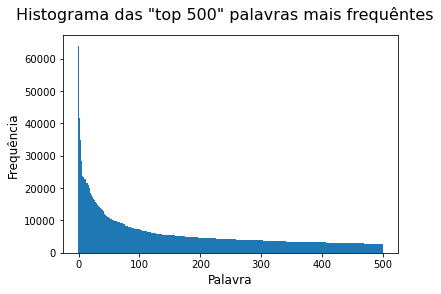

In [16]:
# Histograma das palavras mais frequêntes

indices = np.arange(len(words_sorted_top))
width = 1
fig = plt.figure()
fig.suptitle('Histograma das "top {0}" palavras mais frequêntes'.format(top_n), fontsize=16)
plt.xlabel('Palavra', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.bar(indices, values_sorted_top, width)
plt.show()

## Modelos para bigramas e trigramas

In [17]:
# Constroi modelo para geração de bigramas e trigramas
# Parâmetros:
# min_count (float, optional) – ignora todas as palavras e bigramas com contagem coletada total menor que este valor
# threshold (float, optional) – Representa um score limite para forma a frase ( maior threshold -> menos frases).
# https://radimrehurek.com/gensim/models/phrases.html

bigram = gensim.models.Phrases(data_words, min_count=100, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [18]:
# Funções auxiliares para processamento de bigramas, trigramas e lematização

def gera_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def gera_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lematiza(pipeline, texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # baseado em https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = pipeline(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

## Gera bigramas

In [19]:
# Forma Bigramas
data_words_bigrams = gera_bigrams(data_words_nostopw)


In [20]:
# Mostra os bigramas criados de maior ocorrencia
from collections import Counter
bigram_list = []
for bigram in data_words_bigrams:
    for word in bigram:
        if '_' in word:
            bigram_list.append(word)  
bigram_count = Counter(bigram_list).most_common()
print(str(len(bigram_count)), '\n')
bigram_count

723 



[('minas_gerais', 16425),
 ('sao_paulo', 13991),
 ('espirito_santo', 10252),
 ('estados_unidos', 9320),
 ('cents_libra', 8963),
 ('agricultura_pecuaria', 5342),
 ('libra_peso', 4114),
 ('cerrado_mineiro', 3746),
 ('futures_us', 3159),
 ('assistencia_tecnica', 2951),
 ('cereja_descascado', 2931),
 ('cents_librap', 2753),
 ('nova_york', 2743),
 ('cadeia_produtiva', 2616),
 ('indicador_cepea', 2574),
 ('universidade_federal', 2475),
 ('rio_de_janeiro', 2158),
 ('tipo_duro', 2107),
 ('torrado_moido', 2042),
 ('abastecimento_conab', 1879),
 ('belo_horizonte', 1878),
 ('bebida_dura', 1841),
 ('engenheiro_agronomo', 1720),
 ('america_central', 1647),
 ('mercado_futuro', 1647),
 ('mato_grosso', 1640),
 ('frente_fria', 1551),
 ('condicoes_climaticas', 1517),
 ('diretor_executivo', 1515),
 ('abastecimento_mapa', 1498),
 ('comercio_exterior', 1447),
 ('contratos_futuros', 1436),
 ('fundacao_procafe', 1427),
 ('boas_praticas', 1426),
 ('cup_of', 1421),
 ('cota_futuras', 1397),
 ('pragas_doencas', 

In [21]:
# Inicializando o modelo 'pt' do Spacy
# executar antes: python3 -m spacy download pt
nlp = spacy.load('pt_core_news_lg', disable=['parser', 'ner'])
# Faz lematização, mantendo apenas sunstantivos, adetivos e verbos
data_words_lemmatized = lematiza(nlp, data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])

In [22]:
# Amostra do conjunto de palavras lematizado
print(data_words_lemmatized[0:4])

[['apresentacao', 'pesquisador', 'cientifico', 'coordenador', 'nucleo', 'lavourar', 'cafeeiro', 'pesquisar', 'desenvolvimento', 'mediador', 'comunidade', 'lavourar', 'cafeeiro', 'acreditar', 'redar', 'valer', 'sistema', 'agroindustrial', 'sugerir', 'entrar', 'comunidade', 'apresentar', 'familiarizacao', 'membro', 'colocar', 'disposicao'], ['espaco', 'divulgar', 'pesquisar', 'pessoal', 'colega', 'franquear', 'denominar', 'radar', 'tecnicos', 'pesquisador', 'tecnicos', 'destinar', 'trazer', 'tonar', 'pesquisar', 'alto', 'aplicabilidade', 'feito', 'autor', 'artigo', 'comum', 'articulista', 'apresentar', 'dar', 'preliminar', 'fechar', 'publicar', 'pesquisar', 'realizar', 'desejar', 'divulgar', 'idear', 'resumir', 'trabalhar', 'linguagem', 'simples', 'poder', 'finalizar', 'comentario', 'dar', 'analisar', 'acesso', 'gratuito'], ['espaco', 'divulgar', 'pesquisar', 'pessoal', 'colega', 'franquear', 'denominar', 'radar', 'tecnicos', 'pesquisador', 'tecnicos', 'destinar', 'trazer', 'tonar', 'pes

## Cria o dicionário e o corpus
O dicionário (id2word) e o corpus serão as entradas para obter o LDA topic model pelo Gensim

In [23]:
# Seleciona o conjunto de dados correspondente ao nivel de processamento desejado do conjunto de palavras para alimentar a próxima fase

#data_words_processed = data_words_nostopw
data_words_processed = data_words_bigrams
#data_words_processed = data_words_lemmatized

In [24]:
# Salvando palavras apos remocao de stop words

pickle.dump(data_words_processed, open( "data/save/data_words_processed.pickle", "wb" ))

In [25]:
# Cria o Dicionário
id2word = corpora.Dictionary(data_words_processed)

In [26]:
# Obtém o Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words_processed]

# Amostra do Corpus
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(27, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 2), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 2), (74, 1), (75, 2), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1)]]


In [27]:
#Salvando o dicionário
output_path = 'data/save/'
corpus_name = 'rsc_dictionary'
id2word_dictfile = output_path + corpus_name + '.dict'
id2word.save(id2word_dictfile) 

In [28]:
# Salva corpus no formato Matrix Market
CORPUS_PATH = 'data/save/rsc_corpus.mm'
corpora.MmCorpus.serialize(CORPUS_PATH, corpus)

In [29]:
# Amostra do corpus em formato amigável (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('acredito', 1),
  ('agroindustrial', 1),
  ('apresentacao', 1),
  ('apresentem', 1),
  ('att', 1),
  ('cafeeira', 2),
  ('cientifico', 1),
  ('coloco', 1),
  ('comunidade', 2),
  ('consorcio', 1),
  ('coordenador', 1),
  ('desenvolvimento', 1),
  ('disposicao', 1),
  ('engenheiro_agronomo', 1),
  ('entrem', 1),
  ('familiarizacao', 1),
  ('fitotecnia', 1),
  ('iac', 1),
  ('instituto_agronomico', 1),
  ('lavoura', 2),
  ('manejo', 2),
  ('mediador', 1),
  ('membros', 1),
  ('mestre', 1),
  ('nessa', 1),
  ('nucleo', 1),
  ('pereira', 1),
  ('pesquisa', 1),
  ('pesquisador', 1),
  ('rede', 1),
  ('sergio', 1),
  ('sergio_parreiras', 1),
  ('sistema', 1),
  ('sugiro', 1),
  ('valia', 1)],
 [('pesquisa', 1),
  ('abs', 1),
  ('acesso', 1),
  ('agripoint', 1),
  ('alta', 1),
  ('analisados', 1),
  ('aplicabilidade', 1),
  ('apresentar', 1),
  ('articulista', 1),
  ('artigo', 1),
  ('autor', 1),
  ('cafepoint', 2),
  ('cbp', 1),
  ('colega', 1),
  ('comentario', 1),
  ('comum', 1),
  ('da